# VWAP - Tick Forecast

# Debug: update quantity_behind after placing order aggressively
Set tick factor coefficient to 1. Add some logs to the algo_loop, we find that at bar $9$, after placing order aggressively, the quantity_behind will not update, which causes the endless aggressive trading until the total shares are sold out. Thus, we add a line to update the quantity_behind to eliminate the bug.

During the class, professor set the tick factor to 0 and displayed that it would perfectly follow the VWAP. The reason is if we ignore the tick factor, we will never place order aggressively in our loop (the fair value is always above bid_price), given the specific TSLA TAQ data set.
# Exact number of shares traded
After fixing bug, the total shares traded is slightly less than our target $30000$. The reason is at the last bar we trade passively, and our orders are not guaranteed to be fufilled. In order to finish all the orders, at the last bar, we force it to trade aggressively, which achieve our target more precisely but slightly increase the trading cost.

Another thing that prevents us from trading exact $30000$ shares is that we can only trade mutiple of 100 shares when trading aggressively (round_lot=100). We can not change this because it's determined by the exchange. 

## Pick the best Schedule Factor Coefficient

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

# load our helper functios
import simtools as st
import vwap2_limit_revised as vw

matplotlib.rcParams[ 'figure.figsize' ] = ( 16, 9 )

In [2]:
vwap_coefs = [ 9.95503275e-03, -1.01533564e-04,  5.73879785e-07, -1.47027197e-09, 1.38993793e-12]

In [3]:
# set up some variables
tickfile = 'TSLA-TAQ-jan20.zip'
taq = pd.read_pickle(tickfile)

def filter(df):
    return df[(pd.isna(df.trade_px) == 0) |((pd.isna(df.trade_px) == 1) & ( df.qu_source == 'N') & (df.natbbo_ind == 4 ))]

day1 = taq['2020-01-15']
day1 = filter(day1)
day2 = taq['2020-01-16']
day2 = filter(day2)
day3 = taq['2020-01-17']
day3 = filter(day3)

### Sell

In [4]:
schedule_coefs = np.linspace(-1, 1, 10)
avg_slipperage = []
order_quantity = 300000
order_side = 's'

for i, schedule_coef in enumerate(schedule_coefs):
    results1 = vw.algo_loop(day1, order_side, order_quantity, vwap_coefs, schedule_coef)
    results2 = vw.algo_loop(day2, order_side, order_quantity, vwap_coefs, schedule_coef)
    results3 = vw.algo_loop(day3, order_side, order_quantity, vwap_coefs, schedule_coef)      
    
    slippage1 = results1['day_vwap'] - results1['avg_price']
    slippage2 = results2['day_vwap'] - results2['avg_price']
    slippage3 = results3['day_vwap'] - results3['avg_price']
    print("slipages", slippage1, slippage2, slippage3)
    print("If sell, then slippage smaller better")
    print("If buy, then slippage larger better")
    
    avg_slipperage.append((slippage1 + slippage2 + slippage3)/3)

if order_side == 's':   
    best_schedule_coef = schedule_coefs[np.argmin(avg_slipperage)]
else:
    best_schedule_coef = schedule_coefs_s[np.argmax(avg_slipperage)]

2020-03-27 20:19:12:814402: Beginning VWAP run: s 300000 shares
2020-03-27 20:19:12:814533: schedule_coef: -1.0, tick_coef: 0
Average stock spread for sample: 0.2682
2020-03-27 20:19:12:938041: starting main loop
2020-03-27 20:20:35:597690: end simulation loop
2020-03-27 20:20:35:597813: order analytics
2020-03-27 20:20:35:635396: Quantity Remaining: 0
2020-03-27 20:20:35:635486: VWAP run complete.
2020-03-27 20:20:35:662306: Beginning VWAP run: s 300000 shares
2020-03-27 20:20:35:662405: schedule_coef: -1.0, tick_coef: 0
Average stock spread for sample: 0.2473
2020-03-27 20:20:35:729364: starting main loop
2020-03-27 20:22:19:698451: end simulation loop
2020-03-27 20:22:19:698553: order analytics
2020-03-27 20:22:19:738054: Quantity Remaining: 0
2020-03-27 20:22:19:738181: VWAP run complete.
2020-03-27 20:22:19:768124: Beginning VWAP run: s 300000 shares
2020-03-27 20:22:19:768218: schedule_coef: -1.0, tick_coef: 0
Average stock spread for sample: 0.2104
2020-03-27 20:22:19:810086: st

2020-03-27 20:49:24:259619: end simulation loop
2020-03-27 20:49:24:259719: order analytics
2020-03-27 20:49:24:293451: Quantity Remaining: 0
2020-03-27 20:49:24:293542: VWAP run complete.
2020-03-27 20:49:24:320505: Beginning VWAP run: s 300000 shares
2020-03-27 20:49:24:320610: schedule_coef: 0.33333333333333326, tick_coef: 0
Average stock spread for sample: 0.2473
2020-03-27 20:49:24:387746: starting main loop
2020-03-27 20:51:37:106236: end simulation loop
2020-03-27 20:51:37:106345: order analytics
2020-03-27 20:51:37:143299: Quantity Remaining: 0
2020-03-27 20:51:37:143382: VWAP run complete.
2020-03-27 20:51:37:177544: Beginning VWAP run: s 300000 shares
2020-03-27 20:51:37:177799: schedule_coef: 0.33333333333333326, tick_coef: 0
Average stock spread for sample: 0.2104
2020-03-27 20:51:37:222124: starting main loop
2020-03-27 20:52:53:538035: end simulation loop
2020-03-27 20:52:53:538153: order analytics
2020-03-27 20:52:53:561956: Quantity Remaining: 0
2020-03-27 20:52:53:5620

In [5]:
pickle.dump(schedule_coefs, open("schudule_coefs_s.p", "wb" ))
pickle.dump(avg_slipperage, open("schudule_coefs_avg_slipperage_s.p", "wb" ))
pickle.dump(best_schedule_coef, open("schudule_coefs_s_best.p", "wb" ))
print(best_schedule_coef)

-0.5555555555555556


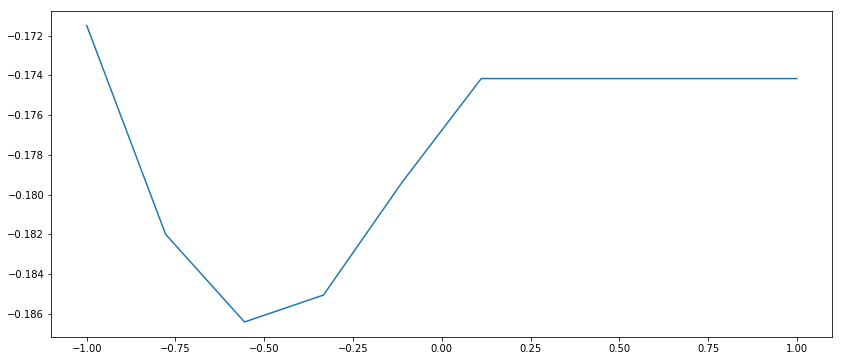

In [14]:
file = open("schudule_coefs_avg_slipperage_s.p",'rb')
avg_slipperage = pickle.load(file)
file.close()

file = open("schudule_coefs_s.p",'rb')
schedule_coefs = pickle.load(file)
file.close()

plt.plot(schedule_coefs, avg_slipperage)

### Buy

In [6]:
schedule_coefs = np.linspace(-1, 1, 10)
avg_slipperage = []
order_quantity = 300000
order_side = 'b'


for i, schedule_coef in enumerate(schedule_coefs):
    results1 = vw.algo_loop(day1, order_side, order_quantity, vwap_coefs, schedule_coef)
    results2 = vw.algo_loop(day2, order_side, order_quantity, vwap_coefs, schedule_coef)
    results3 = vw.algo_loop(day3, order_side, order_quantity, vwap_coefs, schedule_coef)     
    
    slippage1 = results1['day_vwap'] - results1['avg_price']
    slippage2 = results2['day_vwap'] - results2['avg_price']
    slippage3 = results3['day_vwap'] - results3['avg_price']
    print("slipages", slippage1, slippage2, slippage3)
    print("If sell, then slippage smaller better")
    print("If buy, then slippage larger better")
    
    avg_slipperage.append((slippage1 + slippage2 + slippage3)/3)

if order_side == 's':   
    best_schedule_coef = schedule_coefs[np.argmin(avg_slipperage)]
else:
    best_schedule_coef = schedule_coefs[np.argmax(avg_slipperage)]

2020-03-27 21:08:35:240394: Beginning VWAP run: b 300000 shares
2020-03-27 21:08:35:240545: schedule_coef: -1.0, tick_coef: 0
Average stock spread for sample: 0.2682
2020-03-27 21:08:35:298180: starting main loop
2020-03-27 21:10:13:092299: end simulation loop
2020-03-27 21:10:13:092398: order analytics
2020-03-27 21:10:13:126304: Quantity Remaining: 0
2020-03-27 21:10:13:126398: VWAP run complete.
2020-03-27 21:10:13:153119: Beginning VWAP run: b 300000 shares
2020-03-27 21:10:13:153379: schedule_coef: -1.0, tick_coef: 0
Average stock spread for sample: 0.2473
2020-03-27 21:10:13:219684: starting main loop
2020-03-27 21:12:24:572342: end simulation loop
2020-03-27 21:12:24:572438: order analytics
2020-03-27 21:12:24:609399: Quantity Remaining: 0
2020-03-27 21:12:24:609486: VWAP run complete.
2020-03-27 21:12:24:644087: Beginning VWAP run: b 300000 shares
2020-03-27 21:12:24:644314: schedule_coef: -1.0, tick_coef: 0
Average stock spread for sample: 0.2104
2020-03-27 21:12:24:687107: st

2020-03-27 21:40:30:521884: end simulation loop
2020-03-27 21:40:30:521984: order analytics
2020-03-27 21:40:30:555111: Quantity Remaining: 0
2020-03-27 21:40:30:555194: VWAP run complete.
2020-03-27 21:40:30:587588: Beginning VWAP run: b 300000 shares
2020-03-27 21:40:30:587854: schedule_coef: 0.33333333333333326, tick_coef: 0
Average stock spread for sample: 0.2473
2020-03-27 21:40:30:656112: starting main loop
2020-03-27 21:42:26:381257: end simulation loop
2020-03-27 21:42:26:381381: order analytics
2020-03-27 21:42:26:422167: Quantity Remaining: 0
2020-03-27 21:42:26:422256: VWAP run complete.
2020-03-27 21:42:26:458358: Beginning VWAP run: b 300000 shares
2020-03-27 21:42:26:458474: schedule_coef: 0.33333333333333326, tick_coef: 0
Average stock spread for sample: 0.2104
2020-03-27 21:42:26:501099: starting main loop
2020-03-27 21:43:55:663323: end simulation loop
2020-03-27 21:43:55:663427: order analytics
2020-03-27 21:43:55:688956: Quantity Remaining: 0
2020-03-27 21:43:55:6890

In [7]:
pickle.dump(schedule_coefs, open("schudule_coefs_b.p", "wb" ))
pickle.dump(avg_slipperage, open("schudule_coefs_avg_slipperage_b.p", "wb" ))
print(best_schedule_coef)
pickle.dump(best_schedule_coef, open("schudule_coefs_b_best.p", "wb" ))

1.0


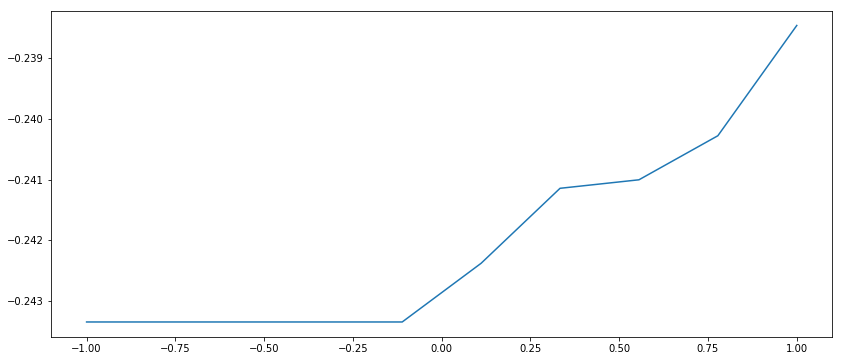

In [15]:
file = open("schudule_coefs_avg_slipperage_b.p",'rb')
avg_slipperage = pickle.load(file)
file.close()

file = open("schudule_coefs_b.p",'rb')
schedule_coefs = pickle.load(file)
file.close()

plt.plot(schedule_coefs, avg_slipperage)

## Pick the best Tick Factor Coefficient

### Sell

In [9]:
#这里统一一下吧定下schedule factor coef 优化tick factor coef
avg_slipperage = []
tick_coefs = np.linspace(-1, 1, 10)
order_quantity = 300000
order_side = 's'

file = open("schudule_coefs_s_best.p",'rb')
best_schedule_coef = pickle.load(file)
file.close()


for i, tick_coef in enumerate(tick_coefs):
    results1 = vw.algo_loop(day1, order_side, order_quantity, vwap_coefs, best_schedule_coef, tick_coef)
    results2 = vw.algo_loop(day2, order_side, order_quantity, vwap_coefs, best_schedule_coef, tick_coef)
    results3 = vw.algo_loop(day3, order_side, order_quantity, vwap_coefs, best_schedule_coef, tick_coef)
    
    slippage1 = results1['day_vwap'] - results1['avg_price']
    slippage2 = results2['day_vwap'] - results2['avg_price']
    slippage3 = results3['day_vwap'] - results3['avg_price']
    print("slipages", slippage1, slippage2, slippage3)
    print("If sell, then slippage smaller better")
    print("If buy, then slippage larger better")
    
    avg_slipperage.append((slippage1 + slippage2 + slippage3)/3)

if order_side == 's':   
    best_tick_coef = tick_coefs[np.argmin(avg_slipperage)]
else:
    best_tick_coef = ticke_coefs[np.argmax(avg_slipperage)]

2020-03-27 22:03:07:829963: Beginning VWAP run: s 300000 shares
2020-03-27 22:03:07:830102: schedule_coef: -0.5555555555555556, tick_coef: -1.0
Average stock spread for sample: 0.2682
2020-03-27 22:03:07:889186: starting main loop
2020-03-27 22:04:41:968912: end simulation loop
2020-03-27 22:04:41:969015: order analytics
2020-03-27 22:04:42:001473: Quantity Remaining: 0
2020-03-27 22:04:42:001557: VWAP run complete.
2020-03-27 22:04:42:031422: Beginning VWAP run: s 300000 shares
2020-03-27 22:04:42:031535: schedule_coef: -0.5555555555555556, tick_coef: -1.0
Average stock spread for sample: 0.2473
2020-03-27 22:04:42:095791: starting main loop
2020-03-27 22:06:28:443653: end simulation loop
2020-03-27 22:06:28:443752: order analytics
2020-03-27 22:06:28:481995: Quantity Remaining: 0
2020-03-27 22:06:28:482082: VWAP run complete.
2020-03-27 22:06:28:516559: Beginning VWAP run: s 300000 shares
2020-03-27 22:06:28:516746: schedule_coef: -0.5555555555555556, tick_coef: -1.0
Average stock sp

2020-03-27 22:30:48:261075: end simulation loop
2020-03-27 22:30:48:261216: order analytics
2020-03-27 22:30:48:284394: Quantity Remaining: 0
2020-03-27 22:30:48:284494: VWAP run complete.
slipages -0.7273857718485033 -0.011235504177022904 0.17826564718023974
If sell, then slippage smaller better
If buy, then slippage larger better
2020-03-27 22:30:48:305446: Beginning VWAP run: s 300000 shares
2020-03-27 22:30:48:305537: schedule_coef: -0.5555555555555556, tick_coef: 0.33333333333333326
Average stock spread for sample: 0.2682
2020-03-27 22:30:48:359970: starting main loop
2020-03-27 22:32:18:494176: end simulation loop
2020-03-27 22:32:18:494273: order analytics
2020-03-27 22:32:18:527960: Quantity Remaining: 0
2020-03-27 22:32:18:528049: VWAP run complete.
2020-03-27 22:32:18:558513: Beginning VWAP run: s 300000 shares
2020-03-27 22:32:18:558712: schedule_coef: -0.5555555555555556, tick_coef: 0.33333333333333326
Average stock spread for sample: 0.2473
2020-03-27 22:32:18:625693: star

In [10]:
pickle.dump(schedule_coefs, open("tick_coefs_s.p", "wb" ))
pickle.dump(avg_slipperage, open("tick_coefs_avg_slipperage_s.p", "wb" ))
print(best_tick_coef)
pickle.dump(best_tick_coef, open("tick_coefs_s_best.p", "wb" ))

1.0


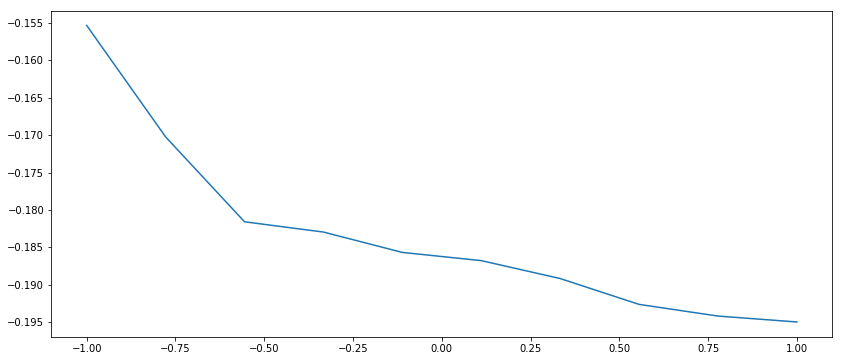

In [16]:
file = open("tick_coefs_avg_slipperage_s.p",'rb')
avg_slipperage = pickle.load(file)
file.close()

file = open("tick_coefs_s.p",'rb')
tick_coefs = pickle.load(file)
file.close()

plt.plot(tick_coefs, avg_slipperage)

### Buy

In [11]:
#这里统一一下吧定下schedule factor coef 优化tick factor coef
avg_slipperage = []
tick_coefs = np.linspace(-1, 1, 10)
order_quantity = 300000
order_side = 'b'

file = open("schudule_coefs_b_best.p",'rb')
best_schedule_coef = pickle.load(file)
file.close()


for i, tick_coef in enumerate(tick_coefs):
    results1 = vw.algo_loop(day1, order_side, order_quantity, vwap_coefs, best_schedule_coef, tick_coef)
    results2 = vw.algo_loop(day2, order_side, order_quantity, vwap_coefs, best_schedule_coef, tick_coef)
    results3 = vw.algo_loop(day3, order_side, order_quantity, vwap_coefs, best_schedule_coef, tick_coef)
    
    slippage1 = results1['day_vwap'] - results1['avg_price']
    slippage2 = results2['day_vwap'] - results2['avg_price']
    slippage3 = results3['day_vwap'] - results3['avg_price']
    print("slipages", slippage1, slippage2, slippage3)
    print("If sell, then slippage smaller better")
    print("If buy, then slippage larger better")
    
    avg_slipperage.append((slippage1 + slippage2 + slippage3)/3)

if order_side == 's':   
    best_tick_coef = tick_coefs[np.argmin(avg_slipperage)]
else:
    best_tick_coef = tick_coefs[np.argmax(avg_slipperage)]

2020-03-27 22:47:16:715990: Beginning VWAP run: b 300000 shares
2020-03-27 22:47:16:716110: schedule_coef: 1.0, tick_coef: -1.0
Average stock spread for sample: 0.2682
2020-03-27 22:47:16:770856: starting main loop
2020-03-27 22:48:35:231514: end simulation loop
2020-03-27 22:48:35:231619: order analytics
2020-03-27 22:48:35:262395: Quantity Remaining: 0
2020-03-27 22:48:35:262479: VWAP run complete.
2020-03-27 22:48:35:292932: Beginning VWAP run: b 300000 shares
2020-03-27 22:48:35:293052: schedule_coef: 1.0, tick_coef: -1.0
Average stock spread for sample: 0.2473
2020-03-27 22:48:35:362745: starting main loop
2020-03-27 22:50:11:677983: end simulation loop
2020-03-27 22:50:11:678084: order analytics
2020-03-27 22:50:11:715232: Quantity Remaining: 0
2020-03-27 22:50:11:715332: VWAP run complete.
2020-03-27 22:50:11:748022: Beginning VWAP run: b 300000 shares
2020-03-27 22:50:11:748204: schedule_coef: 1.0, tick_coef: -1.0
Average stock spread for sample: 0.2104
2020-03-27 22:50:11:7888

2020-03-27 23:14:35:116146: end simulation loop
2020-03-27 23:14:35:116250: order analytics
2020-03-27 23:14:35:148465: Quantity Remaining: 0
2020-03-27 23:14:35:148555: VWAP run complete.
2020-03-27 23:14:35:180285: Beginning VWAP run: b 300000 shares
2020-03-27 23:14:35:180588: schedule_coef: 1.0, tick_coef: 0.33333333333333326
Average stock spread for sample: 0.2473
2020-03-27 23:14:35:250021: starting main loop
2020-03-27 23:16:25:363986: end simulation loop
2020-03-27 23:16:25:364087: order analytics
2020-03-27 23:16:25:402257: Quantity Remaining: 0
2020-03-27 23:16:25:402349: VWAP run complete.
2020-03-27 23:16:25:437268: Beginning VWAP run: b 300000 shares
2020-03-27 23:16:25:437526: schedule_coef: 1.0, tick_coef: 0.33333333333333326
Average stock spread for sample: 0.2104
2020-03-27 23:16:25:481507: starting main loop
2020-03-27 23:17:31:034328: end simulation loop
2020-03-27 23:17:31:034435: order analytics
2020-03-27 23:17:31:058796: Quantity Remaining: 0
2020-03-27 23:17:31:

In [12]:
pickle.dump(schedule_coefs, open("tick_coefs_b.p", "wb" ))
pickle.dump(avg_slipperage, open("tick_coefs_avg_slipperage_b.p", "wb" ))
print(best_tick_coef)
pickle.dump(best_tick_coef, open("tick_coefs_b_best.p", "wb" ))

1.0


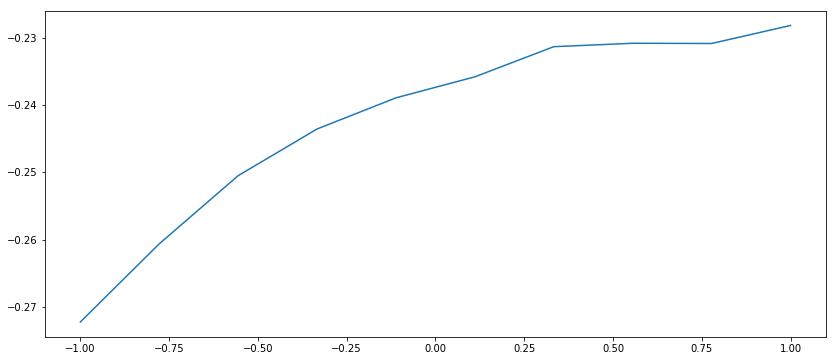

In [17]:
file = open("tick_coefs_avg_slipperage_b.p",'rb')
avg_slipperage = pickle.load(file)
file.close()

file = open("tick_coefs_b.p",'rb')
tick_coefs = pickle.load(file)
file.close()

plt.plot(tick_coefs, avg_slipperage)